In [3]:
from tensorflow.keras.layers import Embedding, Bidirectional, SimpleRNN, Dense, TimeDistributed, Input, MultiHeadAttention, LayerNormalization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Attention, LSTM
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
from nltk.translate.bleu_score import sentence_bleu
import matplotlib.pyplot as plt

In [4]:
# Load training and validation data
train_data = pd.read_csv('train/train.csv')
val_data = pd.read_csv('validation/validation.csv')

# Limit the data to 100 for training and 50 for validation
articles_train = train_data['article'].values[:500]
highlights_train = train_data['highlights'].values[:500]
articles_val = val_data['article'].values[:50]
highlights_val = val_data['highlights'].values[:50]

# Print to verify the sizes
print(f"Training data size: {len(articles_train)} articles, {len(highlights_train)} highlights")
print(f"Validation data size: {len(articles_val)} articles, {len(highlights_val)} highlights")


Training data size: 500 articles, 500 highlights
Validation data size: 50 articles, 50 highlights


In [5]:

# Increase num_words to 20,000 and adjust OOV token
vocab_size = 10000
article_tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
highlight_tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")

# Fit tokenizers on training data
article_tokenizer.fit_on_texts(articles_train)
highlight_tokenizer.fit_on_texts(highlights_train)

# Print tokenizer word indices
print("Article Tokenizer Word Index:")
print(dict(list(article_tokenizer.word_index.items())[:20])) 

print("\nHighlight Tokenizer Word Index:")
print(dict(list(highlight_tokenizer.word_index.items())[:20])) 

Article Tokenizer Word Index:
{'<OOV>': 1, 'the': 2, 'to': 3, 'a': 4, 'and': 5, 'of': 6, 'in': 7, 'was': 8, 'for': 9, 'that': 10, 'on': 11, 'is': 12, 'he': 13, 'with': 14, 'said': 15, 'his': 16, 'it': 17, 'as': 18, 'at': 19, 'have': 20}

Highlight Tokenizer Word Index:
{'<OOV>': 1, 'the': 2, 'to': 3, 'in': 4, 'a': 5, 'and': 6, 'of': 7, 'for': 8, 'was': 9, 'on': 10, 'is': 11, 'he': 12, 'with': 13, 'his': 14, 'at': 15, 'by': 16, 'has': 17, 'be': 18, 'after': 19, 'as': 20}


In [6]:

# Convert texts to sequences
article_sequences_train = article_tokenizer.texts_to_sequences(articles_train)
highlight_sequences_train = highlight_tokenizer.texts_to_sequences(highlights_train)
highlight_sequences_val = highlight_tokenizer.texts_to_sequences(highlights_val)

# Print results of texts_to_sequences
print("Article Sequences (Training):")
print(article_sequences_train[:5])  # Display the first 5 sequences for brevity

print("\nHighlight Sequences (Training):")
print(highlight_sequences_train[:5])  # Display the first 5 sequences for brevity

print("\nHighlight Sequences (Validation):")
print(highlight_sequences_val[:5])  # Display the first 5 sequences for brevity



Article Sequences (Training):
[[21, 1702, 663, 250, 580, 339, 179, 442, 480, 199, 350, 402, 2485, 179, 442, 480, 199, 2, 2628, 6, 2, 6151, 2336, 5431, 7, 307, 8558, 24, 1845, 3767, 664, 6, 1138, 393, 7, 6151, 1378, 1, 5, 1, 3, 2, 7132, 4, 1379, 7, 496, 504, 5, 312, 480, 2, 153, 317, 366, 24, 888, 30, 7133, 6, 3495, 9, 635, 32, 1846, 196, 6152, 5, 191, 1, 2628, 244, 1, 182, 6, 2, 6151, 2336, 5431, 7, 307, 8558, 24, 1845, 3767, 664, 6, 1138, 393, 7, 6151, 1378, 1, 5, 1, 3, 2, 7132, 4, 153, 1, 927, 455, 8559, 1, 118, 2, 1062, 12, 824, 26, 326, 346, 119, 649, 3, 3496, 55, 3, 2, 530, 3495, 2, 5431, 674, 11, 262, 10, 2628, 244, 1, 12, 258, 66, 114, 37, 81, 1847, 14, 7132, 4, 2, 5431, 118, 13, 4098, 2, 4470, 145, 8560, 519, 92, 4884, 4, 944, 9, 2205, 1, 6153, 7, 2206, 72, 209, 2207, 6, 7132, 4, 992, 7134, 1, 889, 6, 8561, 1, 5, 1, 8562, 6151, 2336, 5431, 7, 307, 8558, 182, 12, 98, 2, 2628, 12, 2829], [115, 3768, 2999, 8, 30, 1848, 1703, 3000, 9, 2, 2107, 7135, 71, 366, 333, 7, 2, 2208, 10, 1,

In [7]:

# Pad sequences to fixed length
max_article_len = 100
max_highlight_len = 100 

article_padded_train = pad_sequences(article_sequences_train, maxlen=max_article_len, padding='post')
highlight_padded_train = pad_sequences(highlight_sequences_train, maxlen=max_highlight_len, padding='post')
article_padded_val = pad_sequences(article_tokenizer.texts_to_sequences(articles_val), maxlen=max_article_len, padding='post')
highlight_padded_val = pad_sequences(highlight_sequences_val, maxlen=max_highlight_len, padding='post')



In [47]:
# Define parameters
embedding_dim = 1024
rnn_units = 256

# Define the input layer
inputs = Input(shape=(max_article_len,))

# Embedding layer
x = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_article_len, trainable=True)(inputs)

# Bidirectional SimpleRNN layer
x = Bidirectional(SimpleRNN(rnn_units, return_sequences=True))(x)

# Attention layer with normalization for stability
attention_output = Attention()([x, x])
attention_output = LayerNormalization(epsilon=1e-6)(attention_output + x)

# Dense output layer
outputs = TimeDistributed(Dense(vocab_size, activation='softmax'))(attention_output)

# Build the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 100, 1024)    10240000    ['input_3[0][0]']                
                                                                                                  
 bidirectional_2 (Bidirectional  (None, 100, 512)    655872      ['embedding_2[0][0]']            
 )                                                                                                
                                                                                                  
 attention_2 (Attention)        (None, 100, 512)     0           ['bidirectional_2[0][0]',  

In [49]:

# Train model
history = model.fit(
    article_padded_train, highlight_padded_train,
    epochs=15,  # Increase epochs for better training
    batch_size=16,
    validation_data=(article_padded_val, highlight_padded_val)
)


Epoch 1/15
32/32 [==============================] - 23s 678ms/step - loss: 5.2712 - accuracy: 0.4783 - val_loss: 5.1574 - val_accuracy: 0.4412
Epoch 2/15
32/32 [==============================] - 21s 665ms/step - loss: 4.6517 - accuracy: 0.5000 - val_loss: 5.3781 - val_accuracy: 0.4334
Epoch 3/15
32/32 [==============================] - 21s 657ms/step - loss: 4.5503 - accuracy: 0.4990 - val_loss: 5.5747 - val_accuracy: 0.4230
Epoch 4/15
32/32 [==============================] - 22s 684ms/step - loss: 4.3039 - accuracy: 0.5071 - val_loss: 5.4427 - val_accuracy: 0.4410
Epoch 5/15
32/32 [==============================] - 22s 687ms/step - loss: 4.1972 - accuracy: 0.4994 - val_loss: 5.4614 - val_accuracy: 0.4296
Epoch 6/15
32/32 [==============================] - 21s 667ms/step - loss: 3.8986 - accuracy: 0.5122 - val_loss: 5.5882 - val_accuracy: 0.4392
Epoch 7/15
32/32 [==============================] - 22s 674ms/step - loss: 3.6309 - accuracy: 0.5166 - val_loss: 5.6697 - val_accuracy: 0.4310

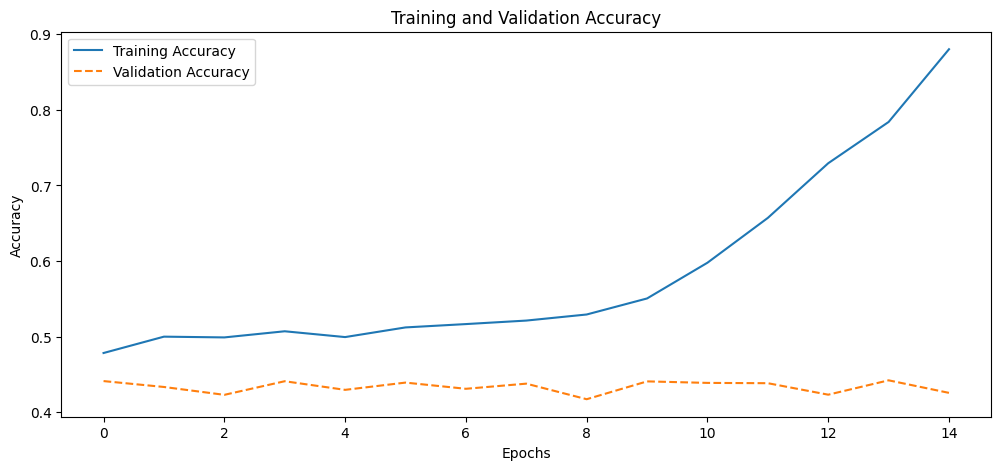

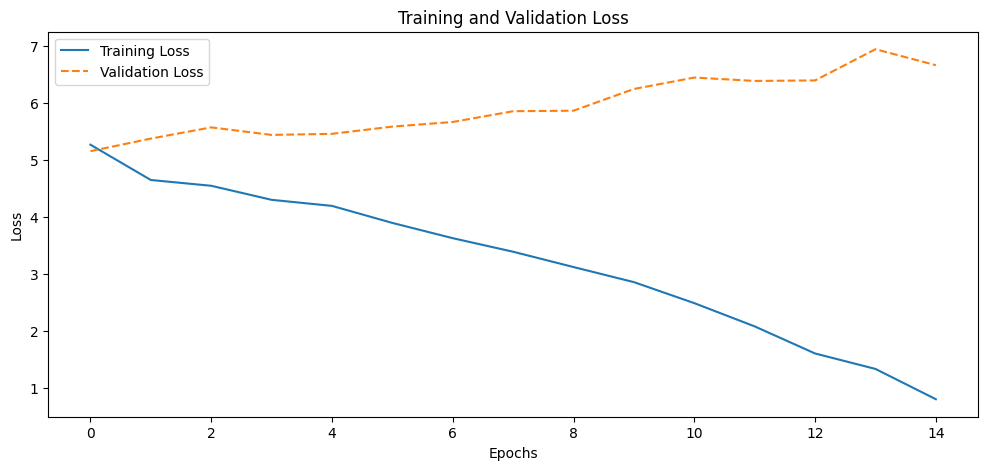

In [50]:
# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [51]:

# Prediction and decoding functions
def decode_sequence(sequence):
    return ' '.join([highlight_tokenizer.index_word.get(i, '') for i in sequence if i != 0])

def generate_summary(article):
    article_sequence = article_tokenizer.texts_to_sequences([article])
    article_padded = pad_sequences(article_sequence, maxlen=max_article_len, padding='post')
    predicted = model.predict(article_padded)
    predicted_sequence = np.argmax(predicted, axis=-1)
    return decode_sequence(predicted_sequence[0])

# BLEU Score Evaluation
bleu_scores = []
for i in range(50):
    predicted_summary = generate_summary(articles_val[i])
    reference_summary = decode_sequence(highlight_padded_val[i])
    score = sentence_bleu([reference_summary.split()], predicted_summary.split())
    bleu_scores.append(score)

average_bleu_score = np.mean(bleu_scores)
print(f'Average BLEU Score: {average_bleu_score}')




1/1 [==============================] - 0s 32ms/step
Average BLEU Score: 0.011024890958055124


In [54]:
print(highlights_val[30])


Female engineer Tina Huang is suing Twitter for gender discrimination .
Claims she was overlooked for promotion in favour of male colleagues .
Says the Silicon Valley firm has no formal procedure for promotions .
And alleges there was a 'shoulder tap' process that favoured men .
Twitter says it is committed to diversity and that she was treated fairly .
Comes as Silicon Valley rocked by two other high profile lawsuits .


In [55]:
# User input for summarization
user_input = articles_val[30]
predicted_summary = generate_summary(user_input)
print("Predicted Summary:", predicted_summary)

1/1 [==============================] - 0s 32ms/step
Predicted Summary: be judy to the for conviction colorado takes children to up cleanup after has a could for as a


In [56]:
print(highlights_train[30])

Richard McLuckie, 48, and Stuart Mackenzie-Walker, 51, invented games .
Won permission from Marmite owner Unilever to use its name and image .
Then they went on investment TV show to ask for funding from the Dragons .
But Unilever contract said entrepreneurs couldn't mention name Marmite .
Three Dragons pulled out, but Peter Jones and Duncan Bannatyne agreed .
They paid the men £50,000 for a 40 per cent stake in board game business .


In [57]:
# User input for summarization
user_input = articles_train[30]
predicted_summary = generate_summary(user_input)
print("Predicted Summary:", predicted_summary)

1/1 [==============================] - 0s 29ms/step
Predicted Summary: richard mcluckie 48 and stuart mackenzie walker 51 invented games won permission from marmite owner unilever to use its name and image then they went of investment tv show to ask the funding his the dragons to unilever contract said entrepreneurs couldn't mention name marmite will dragons pulled to new peter jones and duncan bannatyne agreed they paid the men £50 000 for a 40 per cent stake in board game business
